In [3]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd

# Define a wrapper class for heteroscedastic uncertainty using ensemble predictions
class EnsembleHeteroscedasticRegressor:
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.models = []
        for i in range(self.n_estimators):
            model = clone(self.base_estimator)
            # Bootstrap sampling for ensemble diversity
            indices = rng.choice(len(X), size=len(X), replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
        return self

    def predict(self, X, return_std=False):
        predictions = np.array([model.predict(X) for model in self.models])
        mean_prediction = np.mean(predictions, axis=0)
        if return_std:
            std_prediction = np.std(predictions, axis=0)
            return mean_prediction, std_prediction
        return mean_prediction

from sklearn.base import clone
from sklearn.gaussian_process.kernels import RBF

# Generate synthetic data
X, y = make_regression(n_samples=300, n_features=4, n_targets=3, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Use the custom wrapper per target
hetero_estimators = [
    EnsembleHeteroscedasticRegressor(RandomForestRegressor(n_estimators=50, max_depth=5), n_estimators=10, random_state=i)
    for i in range(y.shape[1])
]

# Fit models
for i in range(len(hetero_estimators)):
    hetero_estimators[i].fit(X_train, y_train[:, i])

# Predict with uncertainty
y_preds = []
y_stds = []
for i in range(len(hetero_estimators)):
    pred, std = hetero_estimators[i].predict(X_test, return_std=True)
    y_preds.append(pred)
    y_stds.append(std)

# Stack results
y_pred = np.stack(y_preds, axis=1)
y_std = np.stack(y_stds, axis=1)

# Show a sample of results
df = pd.DataFrame({
    "Target 1 Prediction": y_pred[:, 0],
    "Target 1 Std": y_std[:, 0],
    "Target 2 Prediction": y_pred[:, 1],
    "Target 2 Std": y_std[:, 1],
    "Target 3 Prediction": y_pred[:, 2],
    "Target 3 Std": y_std[:, 2],
}).round(3)
df

,Target 1 Prediction,Target 1 Std,Target 2 Prediction,Target 2 Std,Target 3 Prediction,Target 3 Std
0,-119.786,24.875,-171.759,12.897,-166.066,37.718
1,-31.063,9.936,-32.651,21.975,25.295,25.570
2,108.437,8.753,84.422,20.975,132.177,30.710
3,-68.147,12.266,-78.998,12.289,-70.180,31.201
4,43.761,9.858,154.615,26.591,213.580,14.779
...,...,...,...,...,...,...
70,16.481,3.175,-36.358,11.873,-69.495,37.574
71,-16.749,7.265,-46.446,28.563,-43.751,32.054
72,47.256,9.089,80.517,31.997,14.702,36.455
73,-79.010,5.937,-155.985,16.876,-208.207,30.137


In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor

# Replace one of the estimators (e.g., the first target) with a Gaussian Process base model
hetero_estimators_gp = hetero_estimators.copy()
hetero_estimators_gp[0] = EnsembleHeteroscedasticRegressor(
    GaussianProcessRegressor(kernel=RBF(length_scale=1.0)), n_estimators=10, random_state=0
)

# Fit models again with the modified GP-based estimator
for i in range(len(hetero_estimators_gp)):
    hetero_estimators_gp[i].fit(X_train, y_train[:, i])

# Predict with uncertainty again
y_preds_gp = []
y_stds_gp = []
for i in range(len(hetero_estimators_gp)):
    pred, std = hetero_estimators_gp[i].predict(X_test, return_std=True)
    y_preds_gp.append(pred)
    y_stds_gp.append(std)

# Stack results
y_pred_gp = np.stack(y_preds_gp, axis=1)
y_std_gp = np.stack(y_stds_gp, axis=1)

# Display updated results
df_gp = pd.DataFrame({
    "Target 1 (GP) Prediction": y_pred_gp[:, 0],
    "Target 1 (GP) Std": y_std_gp[:, 0],
    "Target 2 Prediction": y_pred_gp[:, 1],
    "Target 2 Std": y_std_gp[:, 1],
    "Target 3 Prediction": y_pred_gp[:, 2],
    "Target 3 Std": y_std_gp[:, 2],
}).round(3)

df_gp

,Target 1 (GP) Prediction,Target 1 (GP) Std,Target 2 Prediction,Target 2 Std,Target 3 Prediction,Target 3 Std
0,-107.958,7.241,-168.881,11.560,-165.068,38.889
1,-15.487,0.248,-36.667,18.085,25.013,26.764
2,131.711,6.401,90.970,21.261,140.037,36.677
3,-60.966,0.261,-82.045,17.214,-76.601,32.700
4,66.569,0.789,152.596,36.066,213.157,9.008
...,...,...,...,...,...,...
70,5.132,1.855,-34.968,13.983,-69.880,32.067
71,-17.471,2.188,-44.121,24.783,-33.322,36.457
72,37.355,1.288,76.794,29.486,16.104,43.269
73,-71.466,0.898,-154.686,15.422,-207.442,28.714


In [15]:
# !pip install lightgbm

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 4
[LightGBM] [Info] Start training from score -97.949142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

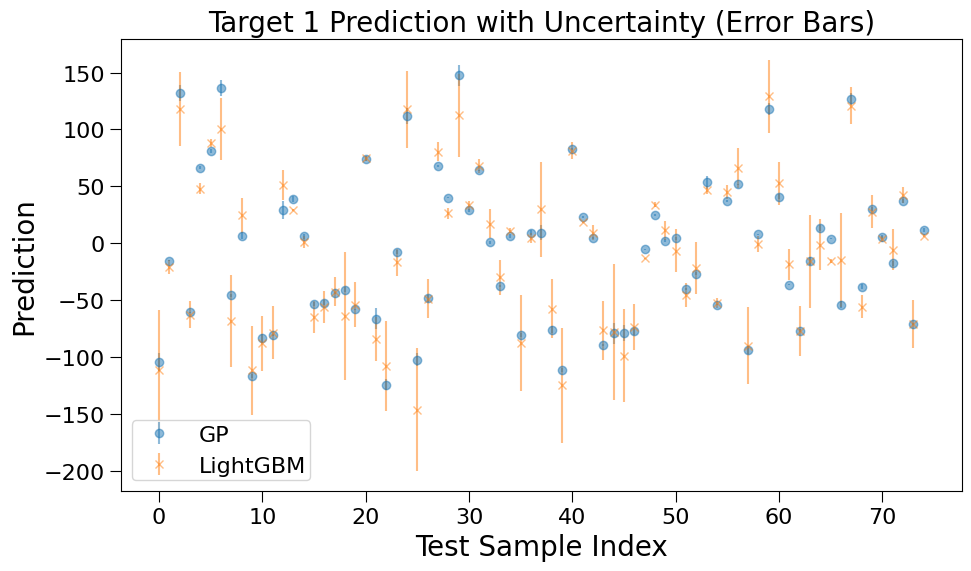

In [8]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.base import clone
import lightgbm as lgb
import matplotlib.pyplot as plt

# ==== Gaussian Process Ensemble Wrapper ====
class EnsembleHeteroscedasticRegressor:
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.models = []
        for _ in range(self.n_estimators):
            model = clone(self.base_estimator)
            indices = rng.choice(len(X), size=len(X), replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
        return self

    def predict(self, X, return_std=False):
        predictions = np.array([model.predict(X) for model in self.models])
        mean_prediction = np.mean(predictions, axis=0)
        if return_std:
            std_prediction = np.std(predictions, axis=0)
            return mean_prediction, std_prediction
        return mean_prediction

# ==== LightGBM Quantile Regressor ====
class LightGBMQuantileRegressor:
    def __init__(self, alpha=0.9, lower_alpha=0.1, **kwargs):
        self.alpha = alpha
        self.lower_alpha = lower_alpha
        self.kwargs = kwargs
        self.model_upper = None
        self.model_lower = None
        self.model_median = None

    def fit(self, X, y):
        self.model_lower = lgb.LGBMRegressor(objective='quantile', alpha=self.lower_alpha, **self.kwargs)
        self.model_upper = lgb.LGBMRegressor(objective='quantile', alpha=self.alpha, **self.kwargs)
        self.model_median = lgb.LGBMRegressor(objective='quantile', alpha=0.5, **self.kwargs)

        self.model_lower.fit(X, y)
        self.model_upper.fit(X, y)
        self.model_median.fit(X, y)
        return self

    def predict(self, X, return_std=False):
        pred = self.model_median.predict(X)
        if return_std:
            upper = self.model_upper.predict(X)
            lower = self.model_lower.predict(X)
            std = np.abs((upper - lower) / 2.0)  # Ensure non-negative
            return pred, std
        return pred

# ==== Generate Synthetic Data ====
X, y = make_regression(n_samples=300, n_features=4, n_targets=3, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# ==== Create Estimators ====
gp_estimators = [
    EnsembleHeteroscedasticRegressor(
        GaussianProcessRegressor(kernel=RBF(length_scale=1.0)), n_estimators=10, random_state=i
    ) for i in range(y.shape[1])
]

lgb_estimators = [
    LightGBMQuantileRegressor(n_estimators=100, max_depth=5, random_state=i)
    for i in range(y.shape[1])
]

# ==== Fit Models ====
for i in range(y.shape[1]):
    gp_estimators[i].fit(X_train, y_train[:, i])
    lgb_estimators[i].fit(X_train, y_train[:, i])

# ==== Predict ====
y_gp_pred, y_gp_std = zip(*[gp_estimators[i].predict(X_test, return_std=True) for i in range(y.shape[1])])
y_lgb_pred, y_lgb_std = zip(*[lgb_estimators[i].predict(X_test, return_std=True) for i in range(y.shape[1])])

y_gp_pred = np.stack(y_gp_pred, axis=1)
y_gp_std = np.stack(y_gp_std, axis=1)
y_lgb_pred = np.stack(y_lgb_pred, axis=1)
y_lgb_std = np.stack(y_lgb_std, axis=1)

# ==== Show Summary ====
df = pd.DataFrame({
    "Target 1 GP Pred": y_gp_pred[:, 0],
    "Target 1 GP Std": y_gp_std[:, 0],
    "Target 1 LGB Pred": y_lgb_pred[:, 0],
    "Target 1 LGB Std": y_lgb_std[:, 0],
    "Target 2 GP Pred": y_gp_pred[:, 1],
    "Target 2 GP Std": y_gp_std[:, 1],
    "Target 2 LGB Pred": y_lgb_pred[:, 1],
    "Target 2 LGB Std": y_lgb_std[:, 1],
    "Target 3 GP Pred": y_gp_pred[:, 2],
    "Target 3 GP Std": y_gp_std[:, 2],
    "Target 3 LGB Pred": y_lgb_pred[:, 2],
    "Target 3 LGB Std": y_lgb_std[:, 2],
})

print("\n=== Sample Predictions ===")
print(df.head())

# ==== Plot uncertainty comparison for Target 1 ====
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_gp_pred)), y_gp_pred[:, 0], yerr=y_gp_std[:, 0],
             label='GP', fmt='o', alpha=0.5)
plt.errorbar(range(len(y_lgb_pred)), y_lgb_pred[:, 0], yerr=y_lgb_std[:, 0],
             label='LightGBM', fmt='x', alpha=0.5)
plt.title("Target 1 Prediction with Uncertainty (Error Bars)")
plt.xlabel("Test Sample Index")
plt.ylabel("Prediction")
plt.legend()
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 4
[LightGBM] [Info] Start training from score -97.949142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

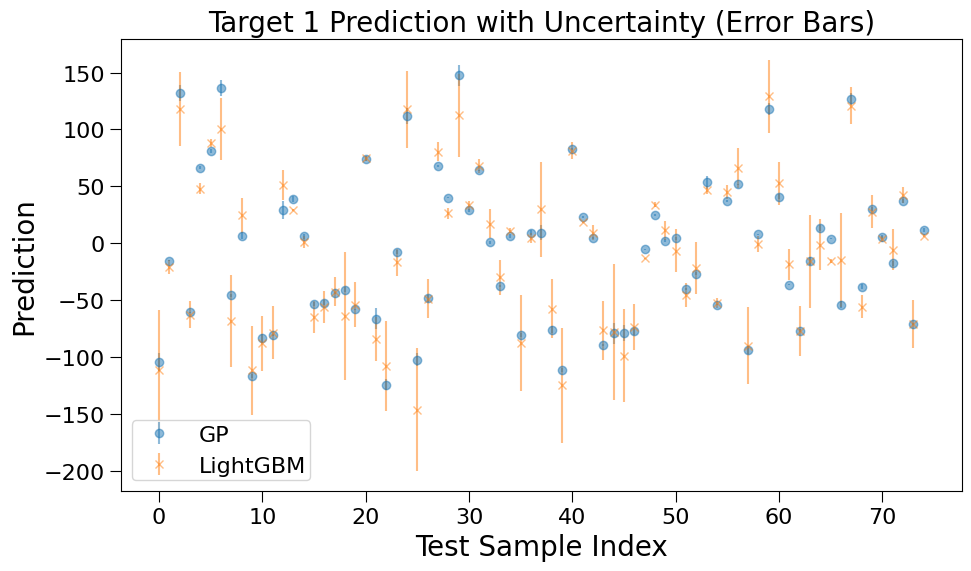

In [9]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.base import clone
import lightgbm as lgb
import matplotlib.pyplot as plt

# ==== Gaussian Process Ensemble Wrapper ====
class EnsembleHeteroscedasticRegressor:
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.models = []
        for _ in range(self.n_estimators):
            model = clone(self.base_estimator)
            indices = rng.choice(len(X), size=len(X), replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
        return self

    def predict(self, X, return_std=False):
        predictions = np.array([model.predict(X) for model in self.models])
        mean_prediction = np.mean(predictions, axis=0)
        if return_std:
            std_prediction = np.std(predictions, axis=0)
            return mean_prediction, std_prediction
        return mean_prediction

# ==== LightGBM Quantile Regressor ====
class LightGBMQuantileRegressor:
    def __init__(self, alpha=0.9, lower_alpha=0.1, **kwargs):
        self.alpha = alpha
        self.lower_alpha = lower_alpha
        self.kwargs = kwargs
        self.model_upper = None
        self.model_lower = None
        self.model_median = None

    def fit(self, X, y):
        self.model_lower = lgb.LGBMRegressor(objective='quantile', alpha=self.lower_alpha, **self.kwargs)
        self.model_upper = lgb.LGBMRegressor(objective='quantile', alpha=self.alpha, **self.kwargs)
        self.model_median = lgb.LGBMRegressor(objective='quantile', alpha=0.5, **self.kwargs)
        self.model_lower.fit(X, y)
        self.model_upper.fit(X, y)
        self.model_median.fit(X, y)
        return self

    def predict(self, X, return_std=False):
        pred = self.model_median.predict(X)
        if return_std:
            upper = self.model_upper.predict(X)
            lower = self.model_lower.predict(X)
            std = np.abs((upper - lower) / 2.0)  # Ensure non-negative std
            return pred, std
        return pred

# ==== Generate Synthetic Data ====
X, y = make_regression(n_samples=300, n_features=4, n_targets=3, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# ==== Create Estimators ====
gp_estimators = [
    EnsembleHeteroscedasticRegressor(
        GaussianProcessRegressor(kernel=RBF(length_scale=1.0)), n_estimators=10, random_state=i
    ) for i in range(y.shape[1])
]

lgb_estimators = [
    LightGBMQuantileRegressor(n_estimators=100, max_depth=5, random_state=i)
    for i in range(y.shape[1])
]

# ==== Fit Models ====
for i in range(y.shape[1]):
    gp_estimators[i].fit(X_train, y_train[:, i])
    lgb_estimators[i].fit(X_train, y_train[:, i])

# ==== Predict ====
y_gp_pred, y_gp_std = zip(*[gp_estimators[i].predict(X_test, return_std=True) for i in range(y.shape[1])])
y_lgb_pred, y_lgb_std = zip(*[lgb_estimators[i].predict(X_test, return_std=True) for i in range(y.shape[1])])

y_gp_pred = np.stack(y_gp_pred, axis=1)
y_gp_std = np.stack(y_gp_std, axis=1)
y_lgb_pred = np.stack(y_lgb_pred, axis=1)
y_lgb_std = np.stack(y_lgb_std, axis=1)

# ==== Show Summary ====
df = pd.DataFrame({
    "Target 1 GP Pred": y_gp_pred[:, 0],
    "Target 1 GP Std": y_gp_std[:, 0],
    "Target 1 LGB Pred": y_lgb_pred[:, 0],
    "Target 1 LGB Std": y_lgb_std[:, 0],
    "Target 2 GP Pred": y_gp_pred[:, 1],
    "Target 2 GP Std": y_gp_std[:, 1],
    "Target 2 LGB Pred": y_lgb_pred[:, 1],
    "Target 2 LGB Std": y_lgb_std[:, 1],
    "Target 3 GP Pred": y_gp_pred[:, 2],
    "Target 3 GP Std": y_gp_std[:, 2],
    "Target 3 LGB Pred": y_lgb_pred[:, 2],
    "Target 3 LGB Std": y_lgb_std[:, 2],
})

print("Sample predictions with uncertainties:")
print(df.head())

# ==== Optional: Plot uncertainty comparison for Target 1 ====
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_gp_pred)), y_gp_pred[:, 0], yerr=y_gp_std[:, 0],
             label='GP', fmt='o', alpha=0.5)
plt.errorbar(range(len(y_lgb_pred)), y_lgb_pred[:, 0], yerr=y_lgb_std[:, 0],
             label='LightGBM', fmt='x', alpha=0.5)
plt.title("Target 1 Prediction with Uncertainty (Error Bars)")
plt.xlabel("Test Sample Index")
plt.ylabel("Prediction")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.base import clone
import matplotlib.pyplot as plt

# ==== Ensemble wrapper for uncertainty estimation ====
class EnsembleRegressor:
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.models = []
        for _ in range(self.n_estimators):
            model = clone(self.base_estimator)
            indices = rng.choice(len(X), size=len(X), replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
        return self

    def predict(self, X, return_std=False):
        predictions = np.array([model.predict(X) for model in self.models])
        mean_prediction = np.mean(predictions, axis=0)
        if return_std:
            std_prediction = np.std(predictions, axis=0)
            return mean_prediction, std_prediction
        return mean_prediction

# ==== Generate synthetic regression data ====
X, y = make_regression(n_samples=300, n_features=4, n_targets=3, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# ==== Create GP and RF regressors per target ====
gp_ensemble = [
    EnsembleRegressor(GaussianProcessRegressor(kernel=RBF()), n_estimators=10, random_state=i)
    for i in range(y.shape[1])
]

rf_ensemble = [
    EnsembleRegressor(RandomForestRegressor(n_estimators=100, max_depth=5), n_estimators=10, random_state=i)
    for i in range(y.shape[1])
]

# ==== Train all models ====
for i in range(y.shape[1]):
    gp_ensemble[i].fit(X_train, y_train[:, i])
    rf_ensemble[i].fit(X_train, y_train[:, i])

# ==== Predict and collect outputs ====
y_gp_pred, y_gp_std = zip(*[gp_ensemble[i].predict(X_test, return_std=True) for i in range(y.shape[1])])
y_rf_pred, y_rf_std = zip(*[rf_ensemble[i].predict(X_test, return_std=True) for i in range(y.shape[1])])

y_gp_pred = np.stack(y_gp_pred, axis=1)
y_gp_std = np.stack(y_gp_std, axis=1)
y_rf_pred = np.stack(y_rf_pred, axis=1)
y_rf_std = np.stack(y_rf_std, axis=1)

# ==== Print comparison ====
df = pd.DataFrame({
    "Target 1 GP Pred": y_gp_pred[:, 0],
    "Target 1 GP Std": y_gp_std[:, 0],
    "Target 1 RF Pred": y_rf_pred[:, 0],
    "Target 1 RF Std": y_rf_std[:, 0],
    "Target 2 GP Pred": y_gp_pred[:, 1],
    "Target 2 GP Std": y_gp_std[:, 1],
    "Target 2 RF Pred": y_rf_pred[:, 1],
    "Target 2 RF Std": y_rf_std[:, 1],
    "Target 3 GP Pred": y_gp_pred[:, 2],
    "Target 3 GP Std": y_gp_std[:, 2],
    "Target 3 RF Pred": y_rf_pred[:, 2],
    "Target 3 RF Std": y_rf_std[:, 2],
})

Sample predictions and uncertainty (GP vs RF):
   Target 1 GP Pred  Target 1 GP Std  Target 1 RF Pred  Target 1 RF Std  \
0       -100.398271         8.321185       -115.475456        23.607882   
1        -15.539875         0.363659        -30.087769         8.831050   
2        131.434855         7.776659        107.795793        10.231444   
3        -60.837212         0.472318        -66.602095        11.964811   
4         66.288823         1.495325         44.394162         8.895616   

   Target 2 GP Pred  Target 2 GP Std  Target 2 RF Pred  Target 2 RF Std  \
0       -203.308889        12.946381       -174.784935         8.899201   
1         16.813412         0.430880        -36.107831        23.643567   
2        183.974119         5.356829         86.353031        20.813583   
3        -78.252541         0.694080        -81.779716        13.421911   
4        152.861090         1.106608        153.218684        33.237404   

   Target 3 GP Pred  Target 3 GP Std  Target 3 RF P

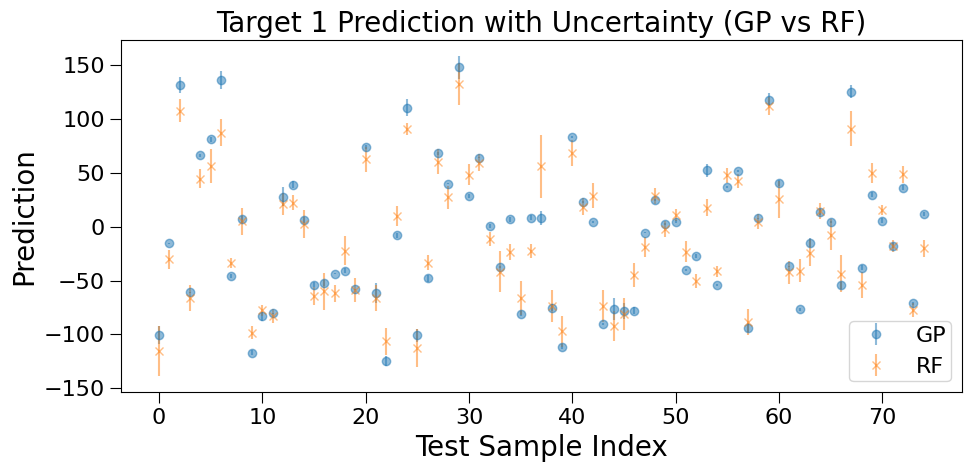

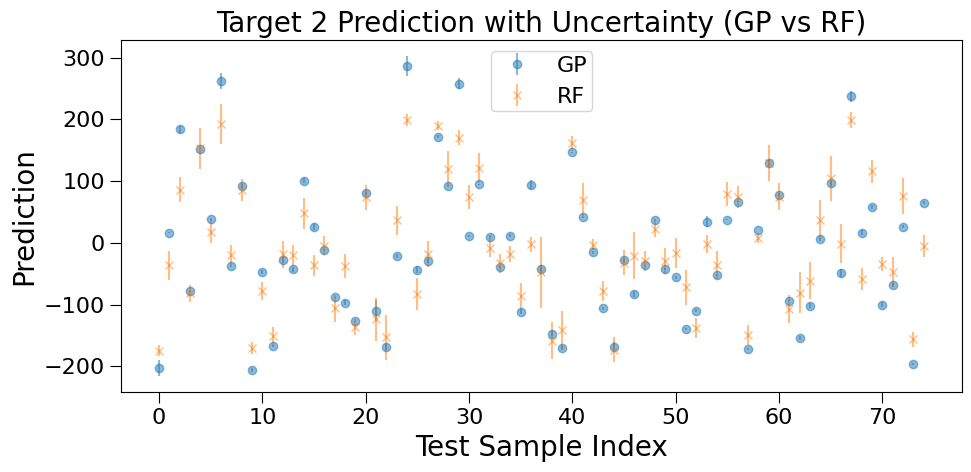

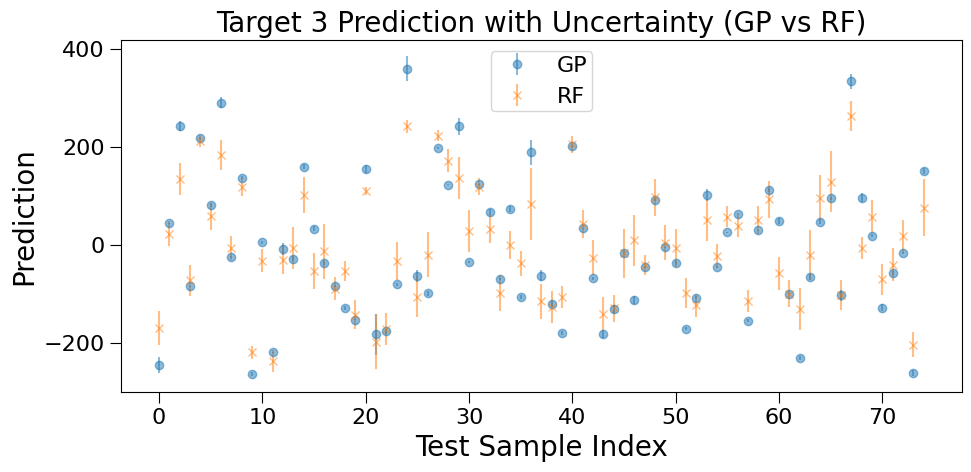

In [18]:
print("Sample predictions and uncertainty (GP vs RF):")
print(df.head())

# ==== Optional: Plot comparison per target ====
for i in range(y.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.errorbar(np.arange(len(y_gp_pred)), y_gp_pred[:, i], yerr=y_gp_std[:, i], fmt='o', alpha=0.5, label='GP')
    plt.errorbar(np.arange(len(y_rf_pred)), y_rf_pred[:, i], yerr=y_rf_std[:, i], fmt='x', alpha=0.5, label='RF')
    plt.title(f"Target {i+1} Prediction with Uncertainty (GP vs RF)")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.base import clone
import matplotlib.pyplot as plt

# === Ensemble Wrapper ===
class EnsembleRegressor:
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.models = []
        for _ in range(self.n_estimators):
            model = clone(self.base_estimator)
            indices = rng.choice(len(X), size=len(X), replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
        return self

    def predict(self, X, return_std=False):
        predictions = np.array([model.predict(X) for model in self.models])
        mean_prediction = np.mean(predictions, axis=0)
        if return_std:
            std_prediction = np.std(predictions, axis=0)
            return mean_prediction, std_prediction
        return mean_prediction

# === Synthetic Multi-target Data ===
X, y = make_regression(n_samples=300, n_features=4, n_targets=3, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# === Build Estimators ===
gp_ensemble = [
    EnsembleRegressor(GaussianProcessRegressor(kernel=RBF()), n_estimators=10, random_state=i)
    for i in range(y.shape[1])
]
rf_ensemble = [
    EnsembleRegressor(RandomForestRegressor(n_estimators=100, max_depth=5), n_estimators=10, random_state=i)
    for i in range(y.shape[1])
]

# === Fit Models ===
for i in range(y.shape[1]):
    gp_ensemble[i].fit(X_train, y_train[:, i])
    rf_ensemble[i].fit(X_train, y_train[:, i])

# === Predict ===
y_gp_pred, y_gp_std = zip(*[gp_ensemble[i].predict(X_test, return_std=True) for i in range(y.shape[1])])
y_rf_pred, y_rf_std = zip(*[rf_ensemble[i].predict(X_test, return_std=True) for i in range(y.shape[1])])

y_gp_pred = np.stack(y_gp_pred, axis=1)
y_gp_std = np.stack(y_gp_std, axis=1)
y_rf_pred = np.stack(y_rf_pred, axis=1)
y_rf_std = np.stack(y_rf_std, axis=1)

# === Confidence Interval Accuracy ===
def interval_accuracy(y_true, y_pred, y_std):
    lower = y_pred - y_std
    upper = y_pred + y_std
    within = ((y_true >= lower) & (y_true <= upper)).astype(int)
    return np.mean(within, axis=0)

gp_acc = interval_accuracy(y_test, y_gp_pred, y_gp_std)
rf_acc = interval_accuracy(y_test, y_rf_pred, y_rf_std)

# # === Print CI Accuracy ===
# for i in range(y.shape[1]):
#     print(f"Target {i+1} CI Accuracy:")
#     print(f"  GP: {gp_acc[i]*100:.1f}% within ±1 std")
#     print(f"  RF: {rf_acc[i]*100:.1f}% within ±1 std")
#     print()

# === Calibration Plot Function ===
def plot_calibration(y_true, y_pred, y_std, title, color, label):
    plt.figure(figsize=(6, 6))
    plt.errorbar(y_pred, y_true, yerr=y_std, fmt='o', alpha=0.4, label=label, color=color)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# # === Plot Calibration per Target ===
# for i in range(y.shape[1]):
#     plot_calibration(y_test[:, i], y_gp_pred[:, i], y_gp_std[:, i],
#                      f"GP Calibration: Target {i+1}", color='tab:blue', label='GP')
#     plot_calibration(y_test[:, i], y_rf_pred[:, i], y_rf_std[:, i],
#                      f"RF Calibration: Target {i+1}", color='tab:orange', label='RF')


/Users/tako/codes/miniconda3/envs/foo310/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/tako/codes/miniconda3/envs/foo310/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Target 1 CI Accuracy:
  GP: 64.0% within ±1 std
  RF: 45.3% within ±1 std

Target 2 CI Accuracy:
  GP: 64.0% within ±1 std
  RF: 36.0% within ±1 std

Target 3 CI Accuracy:
  GP: 74.7% within ±1 std
  RF: 42.7% within ±1 std



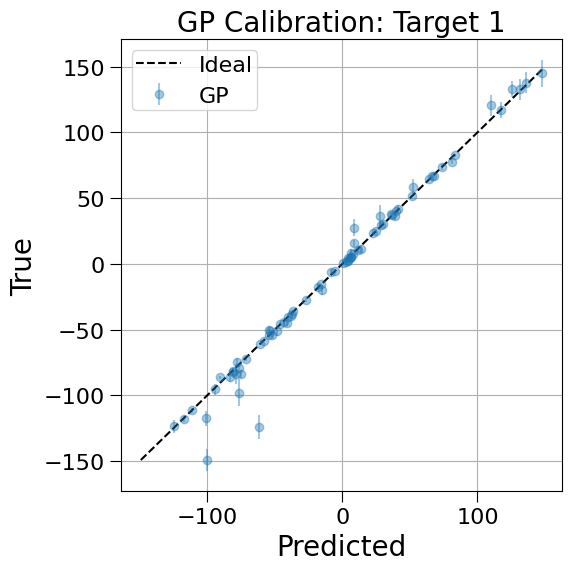

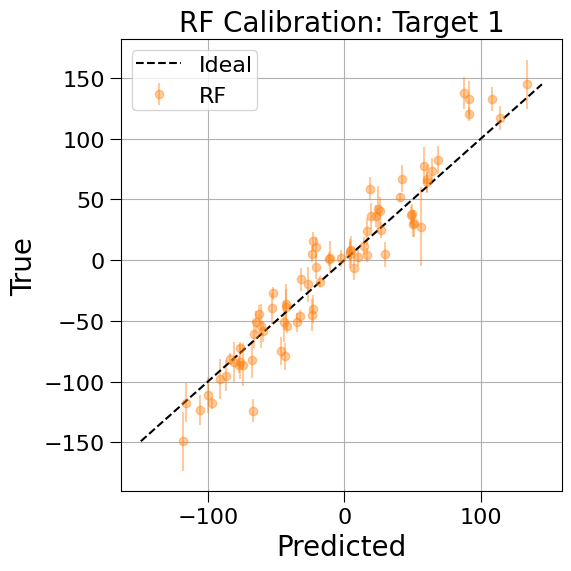

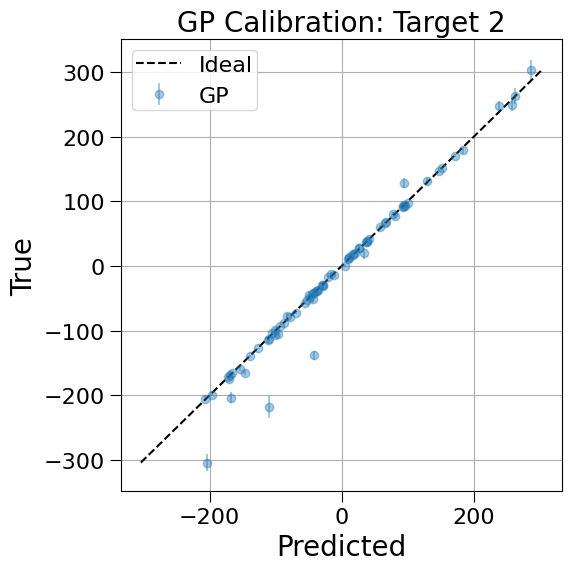

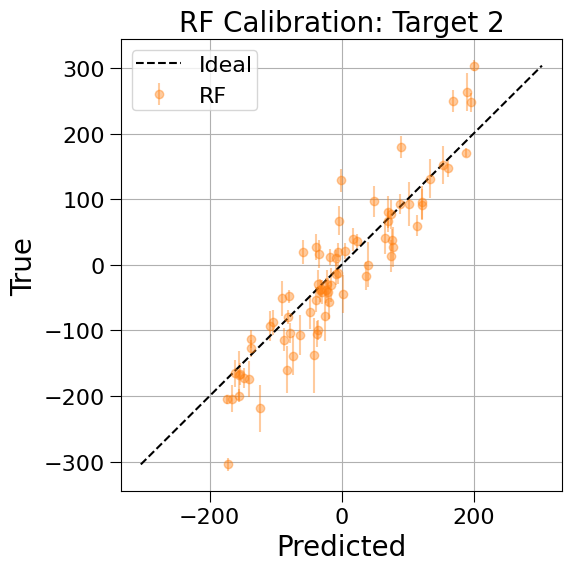

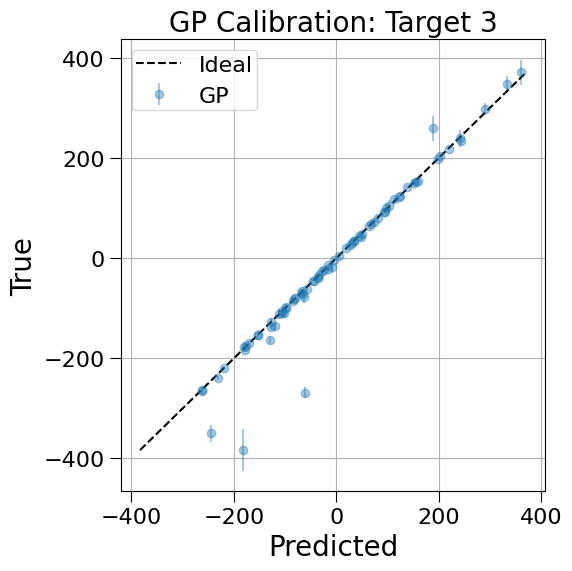

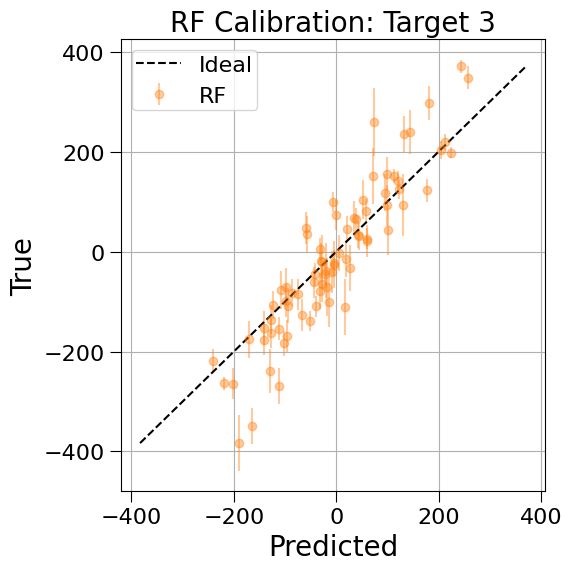

In [22]:
# === Print CI Accuracy ===
for i in range(y.shape[1]):
    print(f"Target {i+1} CI Accuracy:")
    print(f"  GP: {gp_acc[i]*100:.1f}% within ±1 std")
    print(f"  RF: {rf_acc[i]*100:.1f}% within ±1 std")
    print()

# === Plot Calibration per Target ===
for i in range(y.shape[1]):
    plot_calibration(y_test[:, i], y_gp_pred[:, i], y_gp_std[:, i],
                     f"GP Calibration: Target {i+1}", color='tab:blue', label='GP')
    plot_calibration(y_test[:, i], y_rf_pred[:, i], y_rf_std[:, i],
                     f"RF Calibration: Target {i+1}", color='tab:orange', label='RF')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.base import clone, BaseEstimator
import matplotlib.pyplot as plt

# === Ensemble wrapper for uncertainty estimation ===
class EnsembleRegressor(BaseEstimator):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.models = []
        for _ in range(self.n_estimators):
            model = clone(self.base_estimator)
            indices = rng.choice(len(X), size=len(X), replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
        return self

    def predict(self, X, return_std=False):
        predictions = np.array([model.predict(X) for model in self.models])
        mean_prediction = np.mean(predictions, axis=0)
        if return_std:
            std_prediction = np.std(predictions, axis=0)
            return mean_prediction, std_prediction
        return mean_prediction

# === Generate synthetic data ===
X, y = make_regression(n_samples=300, n_features=4, n_targets=3, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# === Define parameter grids ===
gp_param_grid = {
    'alpha': [1e-10, 1e-5],
    'kernel': [C(1.0) * RBF(length_scale=l) for l in [0.5, 1.0, 2.0]],
}

rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
}

# === Hyperparameter-tuned base estimators ===
best_gp_base = []
best_rf_base = []

for i in range(y.shape[1]):
    # --- Gaussian Process ---
    gp = GaussianProcessRegressor()
    gp_search = GridSearchCV(gp, gp_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    gp_search.fit(X_train, y_train[:, i])
    print(f"Best GP params for target {i+1}: {gp_search.best_params_}")
    best_gp_base.append(gp_search.best_estimator_)

    # --- Random Forest ---
    rf = RandomForestRegressor(random_state=42)
    rf_search = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    rf_search.fit(X_train, y_train[:, i])
    print(f"Best RF params for target {i+1}: {rf_search.best_params_}")
    best_rf_base.append(rf_search.best_estimator_)

# === Wrap optimized estimators in EnsembleRegressors ===
gp_ensemble = [
    EnsembleRegressor(base_estimator=best_gp_base[i], n_estimators=10, random_state=i)
    for i in range(y.shape[1])
]
rf_ensemble = [
    EnsembleRegressor(base_estimator=best_rf_base[i], n_estimators=10, random_state=i)
    for i in range(y.shape[1])
]

# === Fit ensembles ===
for i in range(y.shape[1]):
    gp_ensemble[i].fit(X_train, y_train[:, i])
    rf_ensemble[i].fit(X_train, y_train[:, i])

# === Predict and evaluate ===
y_gp_pred, y_gp_std = zip(*[gp_ensemble[i].predict(X_test, return_std=True) for i in range(y.shape[1])])
y_rf_pred, y_rf_std = zip(*[rf_ensemble[i].predict(X_test, return_std=True) for i in range(y.shape[1])])

y_gp_pred = np.stack(y_gp_pred, axis=1)
y_gp_std = np.stack(y_gp_std, axis=1)
y_rf_pred = np.stack(y_rf_pred, axis=1)
y_rf_std = np.stack(y_rf_std, axis=1)

# === Confidence Interval Accuracy ===
def interval_accuracy(y_true, y_pred, y_std):
    lower = y_pred - y_std
    upper = y_pred + y_std
    within = ((y_true >= lower) & (y_true <= upper)).astype(int)
    return np.mean(within, axis=0)

gp_acc = interval_accuracy(y_test, y_gp_pred, y_gp_std)
rf_acc = interval_accuracy(y_test, y_rf_pred, y_rf_std)

for i in range(y.shape[1]):
    print(f"\nTarget {i+1} CI Accuracy:")
    print(f"  GP: {gp_acc[i]*100:.1f}% within ±1 std")
    print(f"  RF: {rf_acc[i]*100:.1f}% within ±1 std")

# # === Optional: Plot GP vs RF Calibration for Target 1 ===
# plt.figure(figsize=(10, 5))
# plt.errorbar(np.arange(len(y_gp_pred)), y_gp_pred[:, 0], yerr=y_gp_std[:, 0],
#              label='GP (Tuned)', fmt='o', alpha=0.4)
# plt.errorbar(np.arange(len(y_rf_pred)), y_rf_pred[:, 0], yerr=y_rf_std[:, 0],
#              label='RF (Tuned)', fmt='x', alpha=0.4)
# plt.title("Target 1 Predictions with Uncertainty (Tuned GP vs RF)")
# plt.xlabel("Sample Index")
# plt.ylabel("Prediction")
# plt.legend()
# plt.tight_layout()
# plt.grid(True)
# plt.show()



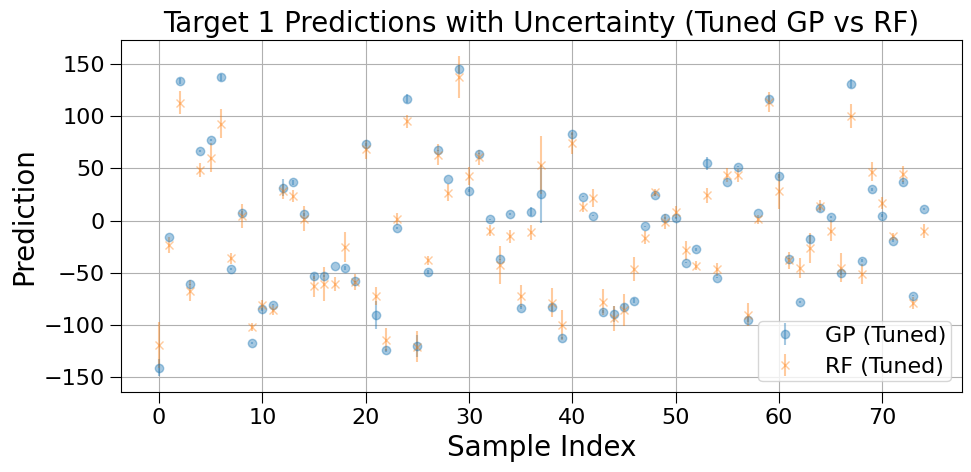

In [24]:
# === Optional: Plot GP vs RF Calibration for Target 1 ===
plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(len(y_gp_pred)), y_gp_pred[:, 0], yerr=y_gp_std[:, 0],
             label='GP (Tuned)', fmt='o', alpha=0.4)
plt.errorbar(np.arange(len(y_rf_pred)), y_rf_pred[:, 0], yerr=y_rf_std[:, 0],
             label='RF (Tuned)', fmt='x', alpha=0.4)
plt.title("Target 1 Predictions with Uncertainty (Tuned GP vs RF)")
plt.xlabel("Sample Index")
plt.ylabel("Prediction")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [26]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, clone

class MixedMultiOutputEnsembleRegressor(BaseEstimator, RegressorMixin):
    """
    Custom multi-output ensemble regressor with mixed base models per target.
    Supports uncertainty estimation via ensemble standard deviation.

    Parameters
    ----------
    base_estimators : list
        A list of scikit-learn regressors (e.g., GP, RF) — one per target.
    n_ensemble : int
        Number of ensemble members per target.
    random_state : int
        Random seed for reproducibility.
    """
    def __init__(self, base_estimators, n_ensemble=10, random_state=None):
        self.base_estimators = base_estimators
        self.n_ensemble = n_ensemble
        self.random_state = random_state

    def fit(self, X, y):
        y = np.asarray(y)
        self.ensemble_models_ = []
        rng = np.random.RandomState(self.random_state)

        for i, base in enumerate(self.base_estimators):
            target_models = []
            for _ in range(self.n_ensemble):
                model = clone(base)
                indices = rng.choice(len(X), size=len(X), replace=True)
                model.fit(X[indices], y[indices, i])
                target_models.append(model)
            self.ensemble_models_.append(target_models)
        return self

    def predict(self, X, return_std=False):
        predictions = []
        stds = []

        for target_models in self.ensemble_models_:
            preds = np.array([model.predict(X) for model in target_models])
            mean = np.mean(preds, axis=0)
            predictions.append(mean)
            if return_std:
                stds.append(np.std(preds, axis=0))

        y_pred = np.stack(predictions, axis=1)
        if return_std:
            y_std = np.stack(stds, axis=1)
            return y_pred, y_std
        return y_pred


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

# Simulate multi-output regression data
X, y = make_regression(n_samples=300, n_features=4, n_targets=3, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Define mixed base models (e.g., GP for T1, RF for T2, GP for T3)
base_models = [
    GaussianProcessRegressor(kernel=RBF(length_scale=1.0)),
    RandomForestRegressor(n_estimators=100, max_depth=5),
    GaussianProcessRegressor(kernel=RBF(length_scale=2.0)),
]

# Initialize and train custom ensemble
model = MixedMultiOutputEnsembleRegressor(base_estimators=base_models, n_ensemble=10, random_state=42)
model.fit(X_train, y_train)

# Predict with uncertainty
y_pred, y_std = model.predict(X_test, return_std=True)

# Print result
import pandas as pd
df = pd.DataFrame({
    "Target 1 Pred": y_pred[:, 0], "T1 Std": y_std[:, 0],
    "Target 2 Pred": y_pred[:, 1], "T2 Std": y_std[:, 1],
    "Target 3 Pred": y_pred[:, 2], "T3 Std": y_std[:, 2],
})


In [29]:
print(df.head())

   Target 1 Pred    T1 Std  Target 2 Pred     T2 Std  Target 3 Pred     T3 Std
0    -101.494873  5.082458    -179.833814  19.887849    -248.396803  14.025762
1     -15.636661  0.337337     -33.786518  17.249878      44.663925   0.836249
2     130.501656  4.934860      88.812010   9.980144     240.588531   7.198494
3     -60.774144  0.545149     -80.713163  13.231793     -84.216788   0.792872
4      67.074652  1.009945     144.488317  28.726972     219.550596   1.719154


In [30]:
model

MixedMultiOutputEnsembleRegressor(base_estimators=[GaussianProcessRegressor(kernel=RBF(length_scale=1)),
                                                   RandomForestRegressor(max_depth=5),
                                                   GaussianProcessRegressor(kernel=RBF(length_scale=2))],
                                  random_state=42)